# Estimating Signalized Intersection Impact on Busses with AVL/APC Data


### Purpose:
The purpose of this notebook is to demonstrate a method for estimating impacts of signalized intersections on busses along bus routes using transit Automatic Vehicle Location (AVL) and Automatic Passenger Count (APC) data. The output is an estimate of delay, queue, and a ranking index, which indicates (highest is best) signals that would benifit most from installation of Transit Signal Priority (TSP) hardware, a common question for transportation agencies wanting to deploy this system. 

The algorithm to split bus routes at traffic signals, categorize bus stop events to determine those associated with traffic signals, determine stop distance from the signal, and to calculate the ranking index metrics was written by me in the "classes" module and this notebook.

The area being investigated in is Florida, and the tranist agency operating the busses is Lynx, which has routes in Orange, Osceole, Polk, and Seminole County.

### Credit for method:

Major credit should be given to author of the masters thesis that this approach is based on. While I wrote the Python code to execute the method, the thesis provided an extensively detailed methodology and framework in which the analysis could be conducted. Here is the citation for the thesis and a link where it can be obtained:

Yang, F. (2012). Estimating bus delay at signalized intersections from archived AVL/APC data. Waterloo, Ont.: University of Waterloo.

https://uwspace.uwaterloo.ca/bitstream/10012/6600/1/yang_fei.pdf 


### Data Sources:

1. AVL/APC Data - Lynx for a four-month period in 2014
2. Traffic Signals - FDOT GIS website
3. County Boundaries - USGS
4. Bus Stop / Shelters - Lynx GIS website


### Import Libraries and Set Directory

Import a series of python libraries to assist with the data analysis. The "classes" module was created specifically for this work and includes a series of helpful objects and methods for estimating transit delay caused by traffic signals.

In [154]:
from classes import *
import numpy as np
import pysal
import shapely.geometry
import shapely.ops
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
%matplotlib inline
pd.options.display.max_columns = 50
pd.options.display.max_rows = 999

Here I have defined directory locations that will be used throughout the analysis:

In [155]:
rootDir = os.getcwd()
rootDataDir = rootDir+"/_data"
oldAPCDataDir = rootDataDir + "/APC Rawdata_OLD" #This is data from kittlesons older analysis of transit routes
oldrawStopData = oldAPCDataDir + "/1404.stp"
projEpsg = {'init': 'epsg:3857'}

### Import Data

Data was obtained from Lynx and was created by their Automatic Vehicle Location (APL) and Automatic Passenger Count (APC) systems that are fitted to Lynx busses. The time frame for the data is a four-month period in 2014.

The stop event data provided by Lynx is denoted with a ".stp" suffix and is a space delimited text file.

In [156]:
rawData = pd.read_fwf(oldrawStopData, delim_whitespace=True)
print len(rawData.index) #Print the number of stops recorded in data
# rawData.head()

1880707


There are nearly 189,000 stop events recorded in the data set.

### Dataframe Cleanup

Split columns that were combined in the import.

In [157]:
rawData['Date'] = rawData['Date  Route'].apply(lambda x: x[0:7])
rawData['Route'] = rawData['Date  Route'].apply(lambda x: x[7:])
# rawData.head()

In [158]:
dropCols = ['Pa', 'DWDI', 'Odom', 'MS_File_', 'GOdom', 'CHT', 
            '104', '201', 'AQC', 'W', '1', '2', 'N', 'E', 'Date  Route', 'PMiles PHours ',
            'D', 'D.1', 'S' ]
cleanedData = rawData.drop(dropCols, axis=1)
cleanedData.head()

,ID,Uniqu,Stop_Name,Arrive,on,off,load,Block,Latitude,Longitud,mile,trip,Erro,Dista,Minu,Bu,Line,DBNN,chd,SRun,ARun,Deviat,Dwell,R,Delta Pattern,Depart,Depari,Date,Route
0,1,3486,UCF SUPERSTOP,55417,5,0,5,43402,28.60071,81.20517,0.0,600,226,0.00,0.0,29,0,1404,600,0.0,0.0,-0.17,5.55,D,67 WESTBOUN,55950,60031,041514,434
1,2,3583,4600 N ALAFAYA TRL AND CENTA,60132,0,0,5,43402,28.60244,81.20749,0.5,600,140,0.50,1.6,29,0,1404,9999,99.9,99.9,99.00,0.00,T,0 WESTBOUN,60132,60132,041514,434
2,3,3584,4600 ALAFAYA TRL AND GEMINI,60228,0,0,5,43402,28.60783,81.20748,0.8,600,58,0.26,0.6,29,0,1404,9999,99.9,99.9,99.00,0.00,T,0 WESTBOUN,60228,60228,041514,434
3,4,3585,4800 N ALAFAYA TRL AND GOLDE,60238,0,0,5,43402,28.60916,81.20749,1.0,600,228,0.24,0.6,29,0,1404,9999,99.9,99.9,99.00,0.00,I,0 WESTBOUN,60238,60238,041514,434
4,5,1154,MCCULLOCH RD AND 3760 ALAFAY,60303,0,0,5,43402,28.61275,81.20753,1.3,600,171,0.26,0.4,29,0,1404,9999,99.9,99.9,99.00,0.00,I,0 WESTBOUN,60303,60303,041514,434


### Create GeoDataFrame

Using the GeoPandas library a GeoDataFrame will be created for the transit stop events, where the provided lat/long coordinates are used to create shapely Point objects in the "geometry" Series. At this point the stop events have not been categorized by any distinction.

In [159]:
geometry = [Point(-x,y) for x,y in zip(cleanedData.Longitud, cleanedData.Latitude)] #Need -x since long is in W
cleanedData = cleanedData.drop(['Latitude', 'Longitud'], axis=1)
crs = {'init': 'epsg:4326'} 
stopGeoFrame = gpd.GeoDataFrame(cleanedData, crs=crs, geometry=geometry)

From plotting and reviewing the data, a some points may have bad coordinate data. Once the points are spatially filtered, these should be adequately removed from the analysis.

In [160]:
stopGeoFrame['Dwell'].describe()

count    1.880707e+06
mean     4.312789e-01
std      2.192726e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.200000e-01
max      9.900000e+01
Name: Dwell, dtype: float64

Interestingly, the dwell times from the data are overwhelmingly 0.0 minutes. I can tell the Dwell time is in minutes by inspecting the deviation time compared to the scheduled arrival time.

It seems impossible for a bus to stop and not have any dwell time, so maybe a stop event is when the bus slows below a threshold and does not necessarily mean it comes to a complete stop. Also the data only reports out to 0.00 minutes, so anything below 1 second of dwell may not be included.

Next the data will be filtered to only include stops where no passengers entered or left the bus and those with larger than zero dwell times, since we are only concerned with actual stops related to traffic signals and not at bus stops where passengers enter and exit

In [161]:
unDefStopsFrame = stopGeoFrame[(stopGeoFrame['on'] == 0) & (stopGeoFrame['off'] == 0) & (stopGeoFrame['Dwell'] != 0)]
print unDefStopsFrame['Dwell'].describe()
# unDefStopsFrame.head()

count    62039.000000
mean         0.682150
std          2.429297
min          0.020000
25%          0.070000
50%          0.130000
75%          0.270000
max         45.400000
Name: Dwell, dtype: float64


In [162]:
reproStops = unDefStopsFrame.to_crs(projEpsg) #Reproject stops
print reproStops.crs
# reproStops.plot()

{'init': 'epsg:3857'}


After the filtering, a different picture of the stop event statistics is painted; this filtering represents a significant reduction in number of data points. Juding from the large maximum dwell, standard deviation, and percentile values, there are stop events included that must be where the bus is parked between bus driver shift or during driver break periods: 45.4 minute dwell would be exessively long for a bus to stand at a bus stop or shelter. 

Next, I will import County boundaries where Lynx runs routes, then filter out stops that fall outside the County boundaries.

In [163]:
counties = gpd.read_file(rootDir+"/_data/cb_2016_us_county_5m/cb_2016_us_county_5m.shp") #Import 5m resolution County boundaries
selectCounties = counties[counties['STATEFP'] == '12']
countyList = ['117', '105', '095', '097'] #Seminole, Orange, Polk, and Osceola County only
selectCounties = selectCounties[selectCounties['COUNTYFP'].isin(countyList)]
selectCounties = selectCounties.to_crs(projEpsg)
print selectCounties.crs
# selectCounties.plot(column='COUNTYFP')
selectCounties.head()

{'init': 'epsg:3857'}


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
232,12,097,00295748,0500000US12097,12097,Osceola,06,3438635835,461982752,POLYGON ((-9090045.493329873 3292805.806083741...
545,12,117,00303665,0500000US12117,12117,Seminole,06,801548741,92787591,POLYGON ((-9067996.664427431 3339194.106200642...
815,12,105,00295747,0500000US12105,12105,Polk,06,4653579442,553462052,POLYGON ((-9140021.042887624 3281697.512850823...
1438,12,095,00295750,0500000US12095,12095,Orange,06,2339574597,258804996,POLYGON ((-9090193.436933136 3346007.139445321...


In [164]:
#Drop stops that fall outside the selectCounties through a spatial join
countyStops = gpd.sjoin(reproStops, selectCounties, how="inner", op="intersects")
countyStops = countyStops.rename(columns=lambda x: x.strip())
countyStops['Route'] = countyStops['Route'].map(lambda x: x.strip())
countyStops = countyStops.drop('index_right', axis=1)
countyStops.head()
# print countyStops.columns

,ID,Uniqu,Stop_Name,Arrive,on,off,load,Block,mile,trip,Erro,Dista,Minu,Bu,Line,DBNN,chd,SRun,ARun,Deviat,Dwell,R,Delta Pattern,Depart,Depari,Date,Route,geometry,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER
50,51,6947,LONGWOOD SUN RAIL,65702,0,0,9,43402,20.7,600,574,0.40,3.9,29,0,1404,655,7.0,8.93,2.03,3.02,D,2757 WESTBOUN,70003,70007,041514,434,POINT (-9055459.863374293 3337473.468256503),12,117,00303665,0500000US12117,12117,Seminole,06,801548741,92787591
51,52,6341,200 SR 434 RD AND MILWEE ST,70119,0,0,9,43402,21.3,600,1147,0.67,5.3,29,0,1404,9999,99.9,99.90,99.00,0.08,D,168 WESTBOUN,70124,70140,041514,434,POINT (-9055517.749509504 3337251.37661805),12,117,00303665,0500000US12117,12117,Seminole,06,801548741,92787591
55,56,6335,1160 SR 434 RD AND ROCK LAKE,70449,0,0,5,43402,22.6,600,19,0.19,0.3,29,0,1404,9999,99.9,99.90,99.00,0.05,D,12 WESTBOUN,70452,70511,041514,434,POINT (-9057865.477570334 3337255.183871998),12,117,00303665,0500000US12117,12117,Seminole,06,801548741,92787591
78,80,6473,GATEWAY DR AND SR 434 RD - EOL,72917,0,0,2,43402,29.0,600,130,0.19,6.5,29,0,1404,721,15.0,19.85,8.28,0.10,D,0 WESTBOUN,72923,72956,041514,434,POINT (-9063277.831212703 3330518.051349281),12,117,00303665,0500000US12117,12117,Seminole,06,801548741,92787591
110,32,6336,200 SR 434 RD AND MILLWEE ST,74854,0,0,12,43402,36.5,730,661,0.15,0.2,29,0,1404,9999,99.9,99.90,99.00,0.05,D,88 EASTBOUN,74857,74932,041514,434,POINT (-9055573.409254901 3337239.95486276),12,117,00303665,0500000US12117,12117,Seminole,06,801548741,92787591


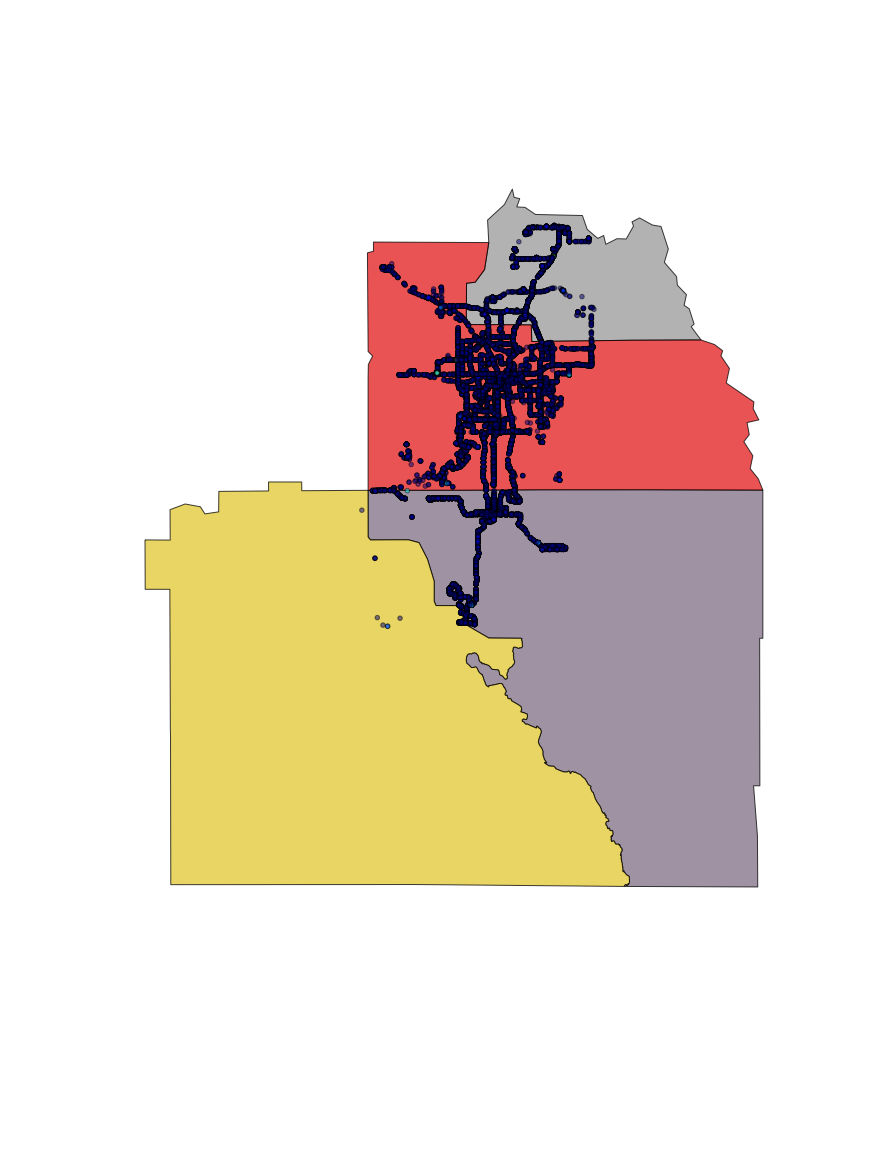

In [165]:
base = selectCounties.plot(column='COUNTYFP', figsize=(20,20), alpha=0.75)
base.set_axis_off()
countyStops.plot(ax=base, column='Dwell', markersize=20, marker='o', alpha=0.5)
plt.show()

From inspection of the map (hard to see at scale plotted in notebook, but easier to see when not plotting in-line) bus stops are fairly easy to distinguish, since there is a large number of stops congregated around them. 

Next, locations of traffic signals need to be added to the map. From there it should be possible see if stops are occuring on traffic signal approaches. The traffic signal locations were obtained from FDOT's GIS data website, and includes flashing beacons, traffic signals, mid-block crossings (signalized), emergency signals, and school signals; therefore, for the purposes of this analysis the data will need to be cleaned to only include traffic signals.

In [166]:
signals = gpd.read_file(rootDataDir + "/traffic_signal_locations/traffic_signal_locations.shp")
signals = signals.to_crs(projEpsg)
base.set_axis_off()
countySignals = gpd.sjoin(signals, selectCounties, how="inner", op="intersects")
countySignals = countySignals[countySignals["VALUE_"] == "02"] #02 only include actual traffic signals
countySignals = countySignals.drop('index_right', axis=1)
countySignals.head()

,RDWYID,SIDE,VALUE_,EFFDATE,CNTLRDES,MAINTAGC,SDESTRET,SIGNALID,SIGNALNC,SIGSTRCT,TYPECABL,SEC_STAT,BEGPT,geometry,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER
2,75270000,C,02,27-JAN-2004,SR 435(KIRKMAN RD),ORLANDO,ARNOLD PALMER DR,75424,N/A,03,02,ON,4.199,POINT (-9067967.477066867 3313470.20226953),12,095,00295750,0500000US12095,12095,Orange,06,2339574597,258804996
32,75040000,C,02,01-JAN-1950,SR 527 NB(ORANGE AV),ORANGE COUNTY,CR 506(HOFFNER AV),75199,N/A,03,02,ON,9.344,POINT (-9057832.489759546 3309103.647569421),12,095,00295750,0500000US12095,12095,Orange,06,2339574597,258804996
53,75040000,C,02,01-JAN-1950,SR 527(ORANGE AV),ORLANDO,ROLLINS ST,75217,N/A,01,N/A,ON,16.382,POINT (-9058385.275356662 3321568.809873201),12,095,00295750,0500000US12095,12095,Orange,06,2339574597,258804996
79,75260000,C,02,01-JAN-1950,SR 434(FOREST CITY),ORANGE COUNTY,RIVERSIDE PARK RD,75415,N/A,03,02,ON,5.925,POINT (-9063065.715347875 3328040.678652911),12,095,00295750,0500000US12095,12095,Orange,06,2339574597,258804996
103,75050000,C,02,28-AUG-1991,SR 50(COLONIAL DR),ORANGE COUNTY,HIGHLAND LK PLAZA,75250,N/A,01,N/A,ON,10.779,POINT (-9070440.759688264 3318743.913559415),12,095,00295750,0500000US12095,12095,Orange,06,2339574597,258804996


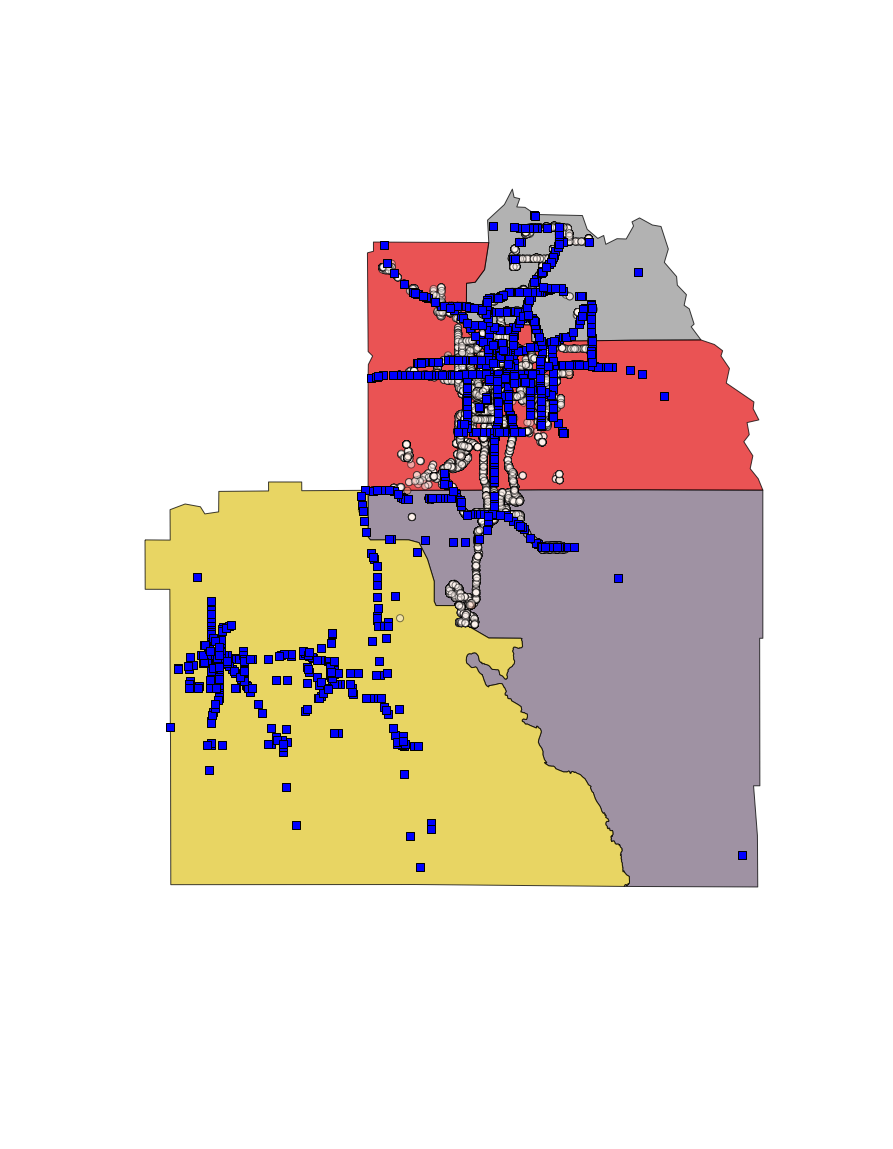

In [167]:
base = selectCounties.plot(column='COUNTYFP', alpha=0.75, figsize=(20,20))
base.set_axis_off()
countyStops.plot(ax=base, column='Dwell', markersize=50, marker='o', cmap='Reds', alpha=0.5)
countySignals.plot(ax=base, markersize=50, marker='s')
plt.show()

### Obtain actual bus stop locations

From review of the stop events and traffic signals plotted on a map (again hard to see when map is plotted in-line), it appears that stop event association method with stop_name may be based on proximity or current destination when the bus stops; therefore, simply removing all stops that have an identified stop_name may also remove stops at traffic signals.

A GeoDataFrame will be created that contains the actual bus stop locations, including stops and shelters. These locations will ultimately be used to filter out stop events that actually occur at bus stops using a spatial join and defined buffer area around each bus stop: points within the buffer will be assumed to be associated with that bus stop and not caused by a traffic signal.

In [168]:
busStops = gpd.read_file(rootDataDir + "/BusStopsAndShelters_Dec2016/LYNX_DBO_BusStops.shp")
busStops = busStops.to_crs(projEpsg)
busShelters = gpd.read_file(rootDataDir + "/BusStopsAndShelters_Dec2016/LYNX_DBO_Shelters.shp")
busShelters = busShelters.to_crs(projEpsg)
busStops = pd.concat([busStops, busShelters], ignore_index=True)
# busStops.head()

### Remove stops that occur at actual bus stops

Now all stop events that fall within a specific raduis of actual bus stops and shelters will be categorizes as "scheduled" stops. These stops will not be used in the transit signal priority analysis.

In [169]:
busStopsInfluence = busStops.copy()[['geometry', 'BSName']]
busStopsInfluence.geometry = busStops.buffer(20.0)
busStopsInfluence.head()

,geometry,BSName
0,POLYGON ((-9061789.019658778 3335120.579286638...,JAMESTOWN BLVD AND SUN VALLEY VLG
1,"POLYGON ((-9052792.95355564 3324955.118676661,...",ALOMA AVE AND ST ANDREWS BLVD
2,"POLYGON ((-9052821.0916637 3337237.468666763, ...",W SR 434 AND CROSS ACCESS EASEMENT
3,POLYGON ((-9049655.324053267 3279575.326867973...,E 17TH ST AND CALIFORNIA AVE
4,POLYGON ((-9067274.146072581 3333713.794119367...,E SR 436 AND S HUNT CLUB BLVD


In [170]:
scheduledStops = gpd.sjoin(countyStops, busStopsInfluence, how="inner", op="intersects")

#Categorize the countyStops... 1 for scheduled 0 for unscheduled
countyStops['scheduled'] = countyStops.index.isin(scheduledStops.index)

#Geoframe of only unscheduled stops
unScheduledStops = countyStops[countyStops['scheduled'] == 0]
unScheduledStops = unScheduledStops.reset_index()
unScheduledStops.head()

,index_left,ID,Uniqu,Stop_Name,Arrive,on,off,load,Block,mile,trip,Erro,Dista,Minu,Bu,Line,DBNN,chd,SRun,ARun,Deviat,Dwell,R,Delta Pattern,Depart,Depari,Date,Route,geometry,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,scheduled
0,50,51,6947,LONGWOOD SUN RAIL,65702,0,0,9,43402,20.7,600,574,0.40,3.9,29,0,1404,655,7.0,8.93,2.03,3.02,D,2757 WESTBOUN,70003,70007,041514,434,POINT (-9055459.863374293 3337473.468256503),12,117,00303665,0500000US12117,12117,Seminole,06,801548741,92787591,False
1,51,52,6341,200 SR 434 RD AND MILWEE ST,70119,0,0,9,43402,21.3,600,1147,0.67,5.3,29,0,1404,9999,99.9,99.90,99.00,0.08,D,168 WESTBOUN,70124,70140,041514,434,POINT (-9055517.749509504 3337251.37661805),12,117,00303665,0500000US12117,12117,Seminole,06,801548741,92787591,False
2,78,80,6473,GATEWAY DR AND SR 434 RD - EOL,72917,0,0,2,43402,29.0,600,130,0.19,6.5,29,0,1404,721,15.0,19.85,8.28,0.10,D,0 WESTBOUN,72923,72956,041514,434,POINT (-9063277.831212703 3330518.051349281),12,117,00303665,0500000US12117,12117,Seminole,06,801548741,92787591,False
3,110,32,6336,200 SR 434 RD AND MILLWEE ST,74854,0,0,12,43402,36.5,730,661,0.15,0.2,29,0,1404,9999,99.9,99.90,99.00,0.05,D,88 EASTBOUN,74857,74932,041514,434,POINT (-9055573.409254901 3337239.95486276),12,117,00303665,0500000US12117,12117,Seminole,06,801548741,92787591,False
4,224,50,6343,100 SR 434 RD AND RONALD RAG,95000,0,0,5,43402,77.8,900,506,0.40,0.9,29,0,1404,9999,99.9,99.90,99.00,0.07,D,150 WESTBOUN,95004,95004,041514,434,POINT (-9055427.580721961 3337408.744024155),12,117,00303665,0500000US12117,12117,Seminole,06,801548741,92787591,False


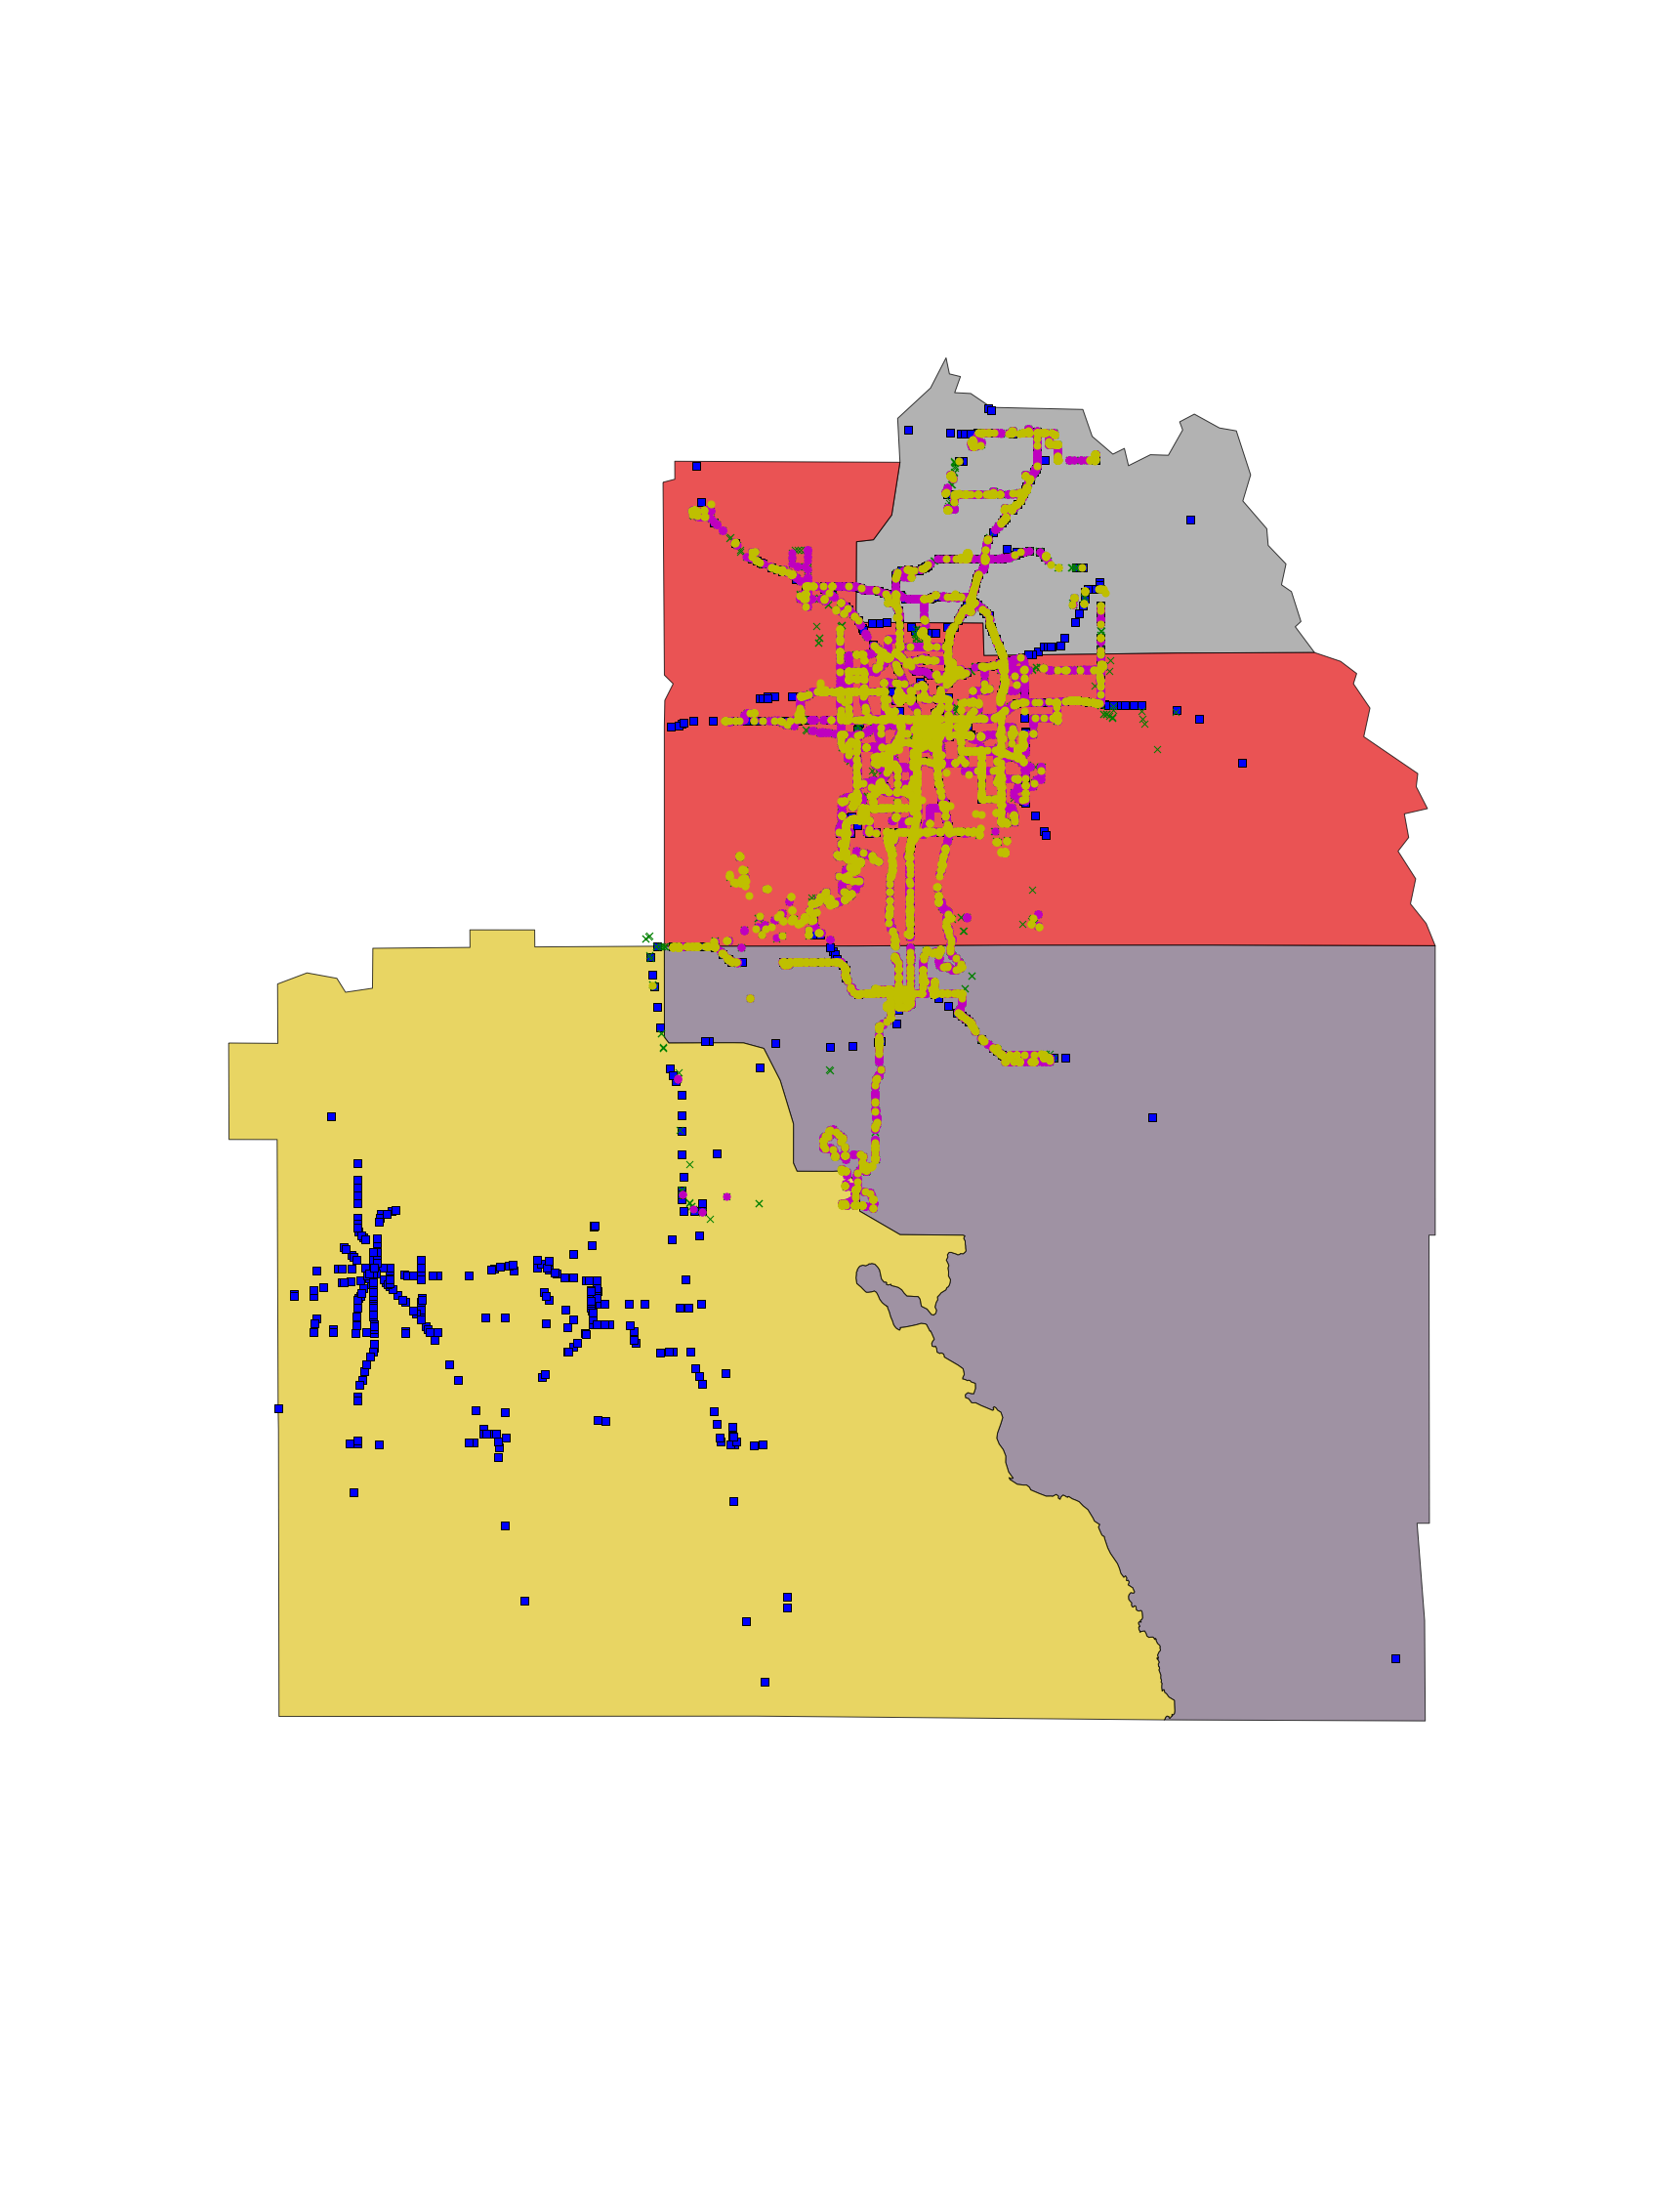

In [171]:
base = selectCounties.plot(column='COUNTYFP', alpha=0.75, figsize=(40,40))
# countyStops.plot(ax=base, column='Dwell', markersize=50, marker='o', cmap='Reds', alpha=0.5)
countySignals.plot(ax=base, markersize=50, marker='s')
base.set_axis_off()
busStops.plot(ax=base, markersize=50, marker='x', color='g')
scheduledStops.plot(ax=base, markersize=50, marker='o', color='m')
unScheduledStops.plot(ax=base, markersize=50, marker='o', color='y')
plt.show()

### Create interactive map of stop events and traffic signals using Bokeh

The Bokeh library facilitates production of interactive HTML maps. The following cells define functions for exporting of Bokeh compatible coordinate structures, and outputs a Bokeh interactive map of traffic signals, bus stops, and unscheduled stop events. From review of the map, it appears that the filtering of stops so far is reasonably effective. The algorithm contained within the classes module written for this analysis will further classify bus stops and determine which are likely caused by the traffic signals on each  bus route; accordingly, some misclasification of scheduled vs. uscheduled stops should be acceptable.

In [172]:
from bokeh.models import (ColumnDataSource, HoverTool, LogColorMapper, GMapPlot, GMapOptions, DataRange1d,
                          Circle, Patches, PanTool, WheelZoomTool, BoxSelectTool)
from bokeh.palettes import RdYlBu11
from bokeh.plotting import figure, save
from bokeh.io import output_file, show


#Code below taken from https://automating-gis-processes.github.io/Lesson5-interactive-map-Bokeh-advanced-plotting.html
def getXYCoords(geometry, coord_type):
    """ Returns either x or y coordinates from  geometry coordinate sequence. Used with LineString and Polygon geometries."""
    if coord_type == 'x':
        return geometry.coords.xy[0]
    elif coord_type == 'y':
        return geometry.coords.xy[1]

def getPolyCoords(geometry, coord_type):
    """ Returns Coordinates of Polygon using the Exterior of the Polygon."""
    ext = geometry.exterior
    return getXYCoords(ext, coord_type)
    
def getLineCoords(geometry, coord_type):
    """ Returns Coordinates of Linestring object."""
    return getXYCoords(geometry, coord_type)

def getPointCoords(geometry, coord_type):
    """ Returns Coordinates of Point object."""
    if coord_type == 'x':
        return geometry.x
    elif coord_type == 'y':
        return geometry.y
    
def multiGeomHandler(multi_geometry, coord_type, geom_type):
    """ 
    Function for handling multi-geometries. Can be MultiPoint, MultiLineString or MultiPolygon. 
    Returns a list of coordinates where all parts of Multi-geometries are merged into a single list. 
    Individual geometries are separated with np.nan which is how Bokeh wants them. 
    # Bokeh documentation regarding the Multi-geometry issues can be found here (it is an open issue)
    # https://github.com/bokeh/bokeh/issues/2321
    """
    
    for i, part in enumerate(multi_geometry):
        # On the first part of the Multi-geometry initialize the coord_array (np.array)
        if i == 0:
            if geom_type == "MultiPoint":
                coord_arrays = np.append(getPointCoords(part, coord_type), np.nan)
            elif geom_type == "MultiLineString":
                coord_arrays = np.append(getLineCoords(part, coord_type), np.nan)
            elif geom_type == "MultiPolygon":
                coord_arrays = np.append(getPolyCoords(part, coord_type), np.nan)
        else:
            if geom_type == "MultiPoint":
                coord_arrays = np.concatenate([coord_arrays, np.append(getPointCoords(part, coord_type), np.nan)])
            elif geom_type == "MultiLineString":
                coord_arrays = np.concatenate([coord_arrays, np.append(getLineCoords(part, coord_type), np.nan)])
            elif geom_type == "MultiPolygon":
                coord_arrays = np.concatenate([coord_arrays, np.append(getPolyCoords(part, coord_type), np.nan)])
    
    # Return the coordinates 
    return coord_arrays
    

def getCoords(row, geom_col, coord_type):
    """
    Returns coordinates ('x' or 'y') of a geometry (Point, LineString or Polygon) 
    as a list (if geometry is LineString or Polygon). 
    Can handle also MultiGeometries.
    """
    # Get geometry
    geom = row[geom_col]
    
    # Check the geometry type
    gtype = geom.geom_type
    
    # "Normal" geometries
    # -------------------
    
    if gtype == "Point":
        return getPointCoords(geom, coord_type)
    elif gtype == "LineString":
        return list( getLineCoords(geom, coord_type) )
    elif gtype == "Polygon":
        return list( getPolyCoords(geom, coord_type) )
        
    # Multi geometries
    # ----------------
    
    else:
        return list( multiGeomHandler(geom, coord_type, gtype) ) 

In [173]:
plotting = False
if plotting:
    color_mapper = LogColorMapper(palette=RdYlBu11)

    countySignals['x'] = countySignals.apply(getCoords, geom_col="geometry", coord_type='x', axis=1)
    countySignals['y'] = countySignals.apply(getCoords, geom_col="geometry", coord_type='y', axis=1)

    unScheduledStops['x'] = unScheduledStops.apply(getCoords, geom_col="geometry", coord_type='x', axis=1)
    unScheduledStops['y'] = unScheduledStops.apply(getCoords, geom_col="geometry", coord_type='y', axis=1)

    selectCounties['x'] = selectCounties.apply(getCoords, geom_col="geometry", coord_type='x', axis=1)
    selectCounties['y'] = selectCounties.apply(getCoords, geom_col="geometry", coord_type='y', axis=1)

    busStops['x'] = busStops.apply(getCoords, geom_col="geometry", coord_type='x', axis=1)
    busStops['y'] = busStops.apply(getCoords, geom_col="geometry", coord_type='y', axis=1)

    signals = countySignals.drop('geometry', axis=1).copy()
    stops = unScheduledStops.drop('geometry', axis=1).copy()
    counties = selectCounties.drop('geometry', axis=1).copy()
    busStops = busStops.drop('geometry', axis=1).copy()

    psSigs = ColumnDataSource(signals)
    psStops = ColumnDataSource(stops)
    psCounties = ColumnDataSource(counties)
    psBusStops = ColumnDataSource(busStops)

    p = figure(title="Signals and Unscheduled Transit Stops", plot_width=1000, plot_height=800, active_scroll="wheel_zoom")

    p.patches('x', 'y', source=psCounties, color='grey', alpha=0.5, line_color='black')
    busStps = p.diamond('x', 'y', source=psBusStops, color='olive', size=5, legend="Bus Stops")
    sigs = p.square('x', 'y', source=psSigs, color='green', size=5, legend="Traffic Signals")
    stps = p.circle('x', 'y', source=psStops, fill_color={'field': 'Dwell', 'transform': color_mapper}, fill_alpha=1.0, 
                    color='blue', size=5, legend="Stop Events")


    sig_hover = HoverTool(renderers=[sigs])
    sig_hover.tooltips = [("Main Rd", "@CNTLRDES"),
                          ("Side St", "@SDESTRET")]

    stps_hover = HoverTool(renderers=[stps])
    stps_hover.tooltips = [("Bus", "@Bu"), 
                           ("Route", "@Route"),
                           ("Dwell", "@Dwell")]

    busStps_hover = HoverTool(renderers=[busStps])
    busStps_hover.tooltips = [("Bus Stop Name", "@BSName")]

    p.add_tools(sig_hover)
    p.add_tools(stps_hover)
    p.add_tools(busStps_hover)

    outfp = rootDir+'/Signals & Unscheduled Transit Stops Map.html'
    save(p, outfp)

### Import Bus Route Shapefiles and Build Directional Routes

Unfortunately Lynx shp files for thier bus routes are not created in a order that permits simple directional analysis. The segments appear to be randomly ordered, and to execute the algoritm provided in the "classes" module the bus routes must be directional, from start to finish, and be broken per inbound and outbound portions. I attempted to build routes from sequential stop information using Python, but this only provided lines connected to stop points, and while these lines were directional and broken per inbound and outbound directions, the roadway geometry was lost. This was most obvious when busses travesed interstates between stops; there would be a long straight line between stops that did not follow the interstate. For the analysis at hand roadway geometry is critically important. Finding a way to automatically create routes would expand the general utility of this methodology. However for the current analysis bus routes were manually created using a point-to-line conversion in QGIS where I manually created the directional routes.

3.56672606365


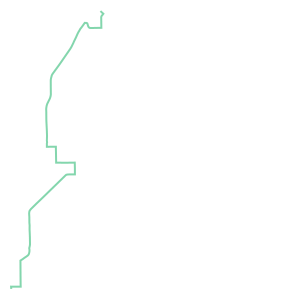

In [174]:
route102 = gpd.read_file(rootDir+"/GIS/testRoute102_0.shp")
route102 = route102.to_crs(projEpsg)
print route102.geometry[0].length/5280

route102.geometry[0]

Above is Lynx Route 102 in only the outbound direction. This route was chosen for demonstration, since it had a large number of signals and high potential for traffic signal related stops; the method demonstrated is applicable for any bus route with traffic signals. Route 102 outbound is around 3.6 miles long.

In [175]:
testSignals = [SignalizedIntersection(countySignals.iloc[i]['CNTLRDES']+'@'+countySignals.iloc[i]['SDESTRET'], 
                                      countySignals.geometry.iloc[i]) for i in xrange(len(countySignals.index))]

#Filter to only include stops on route being analyzed
route102Stops = unScheduledStops[unScheduledStops['Route'] == '102']
route102Stops.head()

,index_left,ID,Uniqu,Stop_Name,Arrive,on,off,load,Block,mile,trip,Erro,Dista,Minu,Bu,Line,DBNN,chd,SRun,ARun,Deviat,Dwell,R,Delta Pattern,Depart,Depari,Date,Route,geometry,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,scheduled
16,22043,99,9999,Not Identified - Cal,63751,0,0,0,10212,7.7,638,1500,5.55,20.0,33,0,1404,9999,99.9,99.9,0.00,0.02,D,0 INBOUND,63752,63752,042414,102,POINT (-9054844.266590204 3331999.67391368),12,117,00303665,0500000US12117,12117,Seminole,06,801548741,92787591,False
17,22147,49,1074,1000 LAKE OF THE WOODS BLVD,81130,0,0,0,10212,27.7,730,131,0.14,0.3,33,0,1404,9999,99.9,99.9,99.00,0.15,D,65 OUTBOUND,81139,81356,042414,102,POINT (-9055015.698606027 3331213.175633377),12,117,00303665,0500000US12117,12117,Seminole,06,801548741,92787591,False
19,22209,1,1064,FERNWOOD BLVD AND OXFORD RD,93442,0,0,0,10212,46.8,938,129,0.00,0.0,33,0,1404,938,0.0,0.0,0.72,4.02,D,43 INBOUND,93843,93924,042414,102,POINT (-9054855.398539284 3332008.553998482),12,117,00303665,0500000US12117,12117,Seminole,06,801548741,92787591,False
20,22374,1,1064,FERNWOOD BLVD AND OXFORD RD,122906,0,0,0,10212,86.0,1238,45,0.00,0.0,33,0,1404,1238,0.0,0.0,0.07,8.97,D,242 INBOUND,123804,123847,042414,102,POINT (-9054775.248505913 3331945.12495141),12,117,00303665,0500000US12117,12117,Seminole,06,801548741,92787591,False
24,22539,1,1064,FERNWOOD BLVD AND OXFORD RD,153026,0,0,0,10212,25.2,1538,82,0.00,0.0,33,0,1404,1538,0.0,0.0,-1.30,6.27,D,8 INBOUND,153642,153724,042414,102,POINT (-9054846.49298002 3332009.822582508),12,117,00303665,0500000US12117,12117,Seminole,06,801548741,92787591,False


A list of Stop class objects, from the "classes" module, need to be created. This is done in the following cell.

In [176]:
routeStops = [Stop(route102Stops['Dwell'].iloc[i], route102Stops.geometry.iloc[i]) for i in range(len(route102Stops.index))]

The following cell shows how the analysis method in "classes" is executed. 

1. Find the number of trips on the bus route over the analysis period corresponding to the stop event data.
2. Create a Route object.
3. Split the route at traffic signal locations using the split_route_at_signals method.
4. Calculate the ranking index for each traffic signal on the route.


Note that numTrips below, or the number of bus trips on the route in the dataset, was set at for ease in verifying the methodology. It could easily be obtained through grouping and aggregating of the bus trip data.

In [177]:
numTrips = 1 #This number is only for demonstration purposes!!
Route1 = Route("Route 102 NB", route102.geometry[0], numTrips, routeStops)
Route1.split_route_at_signals(testSignals, bufferWidth=200, sigRadius=1, debug=False)
calc_system_ranking_index([Route1], print_seg_metrics=True, print_ranking=True, plot_seg_classification=False)

No points found in Segment Route 102 NB_1
No points found in Segment Route 102 NB_1
Segment: Route 102 NB_1 _________________________________________
Signal: SR400(I-4EBOFF RAMP)@AMELIA AV
Mean Stop Delay: 0.3
Standard Dev of Stop Delay: 0.0
90th Percentile Stop Delay: 0.3
Maximum Queue Length: 4.74902
Saturation Degree Indicator: 3.16601
Maximum Delay: 0.867
Proportion Stopped at Signal: 1.0
Segment: Route 102 NB_1 _________________________________________
Signal: SR 527(MAGNOLIA AV)@SR 50(COLONIAL DR)
Mean Stop Delay: 0.15
Standard Dev of Stop Delay: 0.0895668589503
90th Percentile Stop Delay: 0.226
Maximum Queue Length: 180.805
Saturation Degree Indicator: 144.644
Maximum Delay: 0.672
Proportion Stopped at Signal: 9.0
Segment: Route 102 NB_1 _________________________________________
Signal: SR 527(MAGNOLIA AV)@MARKS ST
Mean Stop Delay: 0.122222222222
Standard Dev of Stop Delay: 0.0456503079648
90th Percentile Stop Delay: 0.18
Maximum Queue Length: 423.995
Saturation Degree Indicator

The "classes" module prints some warnings when no stop events are found on a segment (section of road between traffic signals along routes), and when the segment metric calculations fail. Using kwargs, some printing and plotting functions can be accessed that help inspect what is happening under the hood and to print the signalized intersection impact metrics on bus operations.

Commonly the segment metric calculations fail due to lack of stop event data near the signal on the approach, in these cases the algorithm is not able to classify any stops as being traffic signal related. As a result, these signals are provided a 0.0 index ranking score, which is an acceptable output since no buses are stopping at these signals.

Below the signalized intersections have been sorted based on the Ranking Index. 

In [178]:
rankings = {"Signal ID": [signal.signalID for signal in Route1.filteredSignals],
            "Ranking Index": [signal.rankingIndex for signal in Route1.filteredSignals],
            "geometry": [Point(signal.coords) for signal in Route1.filteredSignals]}
rankFrame = gpd.GeoDataFrame(rankings, geometry='geometry')
rankFrame = rankFrame.sort_values(by="Ranking Index", ascending=False).reset_index()
rankFrame

,index,Ranking Index,Signal ID,geometry
0,24,0.858537,US 17-92(ORLANDO AV)@WEBSTER AV,POINT (-9057518.681400567 3325280.256707661)
1,18,0.611734,SR400(I-4EBOFF RAMP)@AMELIA AV,POINT (-9059403.267247407 3318403.135642602)
2,11,0.584298,SR 527(ORANGE AV)@KING ST,POINT (-9058395.345188424 3321881.688739909)
3,13,0.444306,SR 527(MAGNOLIA AV)@MARKS ST,POINT (-9058835.468941096 3319372.496171347)
4,17,0.443441,SR 527(MAGNOLIA AV)@SR 50(COLONIAL DR),POINT (-9058831.274887018 3318908.514108486)
5,5,0.415047,US 17-92(ORLANDO AV)@SYBELIA AV,POINT (-9057321.96573323 3328750.504846735)
6,3,0.386050,US 17-92(ORLANDO AV)@HORATIO AV,POINT (-9057336.767204976 3328269.139414825)
7,16,0.291573,US 17-92(ORLANDO AV)@GREENWOOD RD,POINT (-9056871.50897957 3329467.208750106)
8,7,0.280146,US 17-92(ORLANDO AV)@PARK AV,POINT (-9057546.534522401 3326507.879242597)
9,23,0.276508,SR 426(FAIRBANKS AV)@PENNSYLVANIA AV,POINT (-9056561.780171959 3323961.279202747)


Next a map is plotted to graphically depict the signalized intersection rankings, where darker fill indicates larger ranking index.

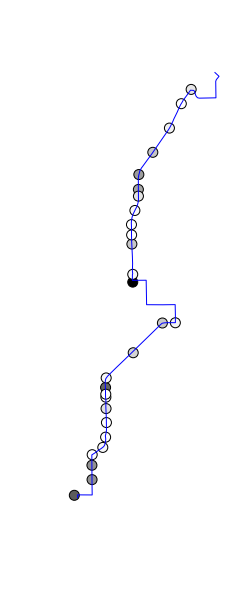

In [179]:
base = route102.plot(figsize=(10,10))
base.set_axis_off()
rankFrame.plot(ax=base, column='Ranking Index', cmap='Greys', markersize=100)
plt.show()

### Conclusion:

In this notebook a method for estimating impacts to transit bus operations by traffic signals was demonstrated using Python, and one direction of one bus route was used as the means of demonstration. Furthermore, a means to prioritize deployment locations for transit signal priority equipment was provided. The method demonstrated is extensible to any bus route with traffic signals located along the route; however, an automated means for obtaining directional bus route geometry should be developed for improved usability. 

Since calculating delay and queue values for transit buses is indicative of the overall flow of traffic, these parameters and demonstrated method have the potential for more general applications in traffic flow analysis and signal performance measurement. If AVL/APC data is avaliable for buses travel along a corridor, and an adequate number of bus trips exist in the data along the corridor, this data could be used to calculate traffic signal performance along the corridor without the need for separate data collection usually required for performance measurement, which is in general a resource intensive operation. 